In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings

import numpy as np
import gsw
import xarray as xr
from xgcm import Grid
from xhistogram.xarray import histogram
from dask.diagnostics import ProgressBar

import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon
import regionmask

import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import cmocean

import cartopy.crs as ccrs
import cartopy.feature as cfeature
data_crs = ccrs.PlateCarree()

In [3]:
import xwmb.theta as xwm
import sectionate as sec
import regionate as reg

In [46]:
import dask

### Load grids and data

In [185]:
gridname = 'rho2'
dt = '6hourly' # choose from ['monthly', '6hourly', 'timestp']

# Load data on native grid
rootdir = '/archive/gam/MOM6-examples/ice_ocean_SIS2/Baltic_OM4_025/ocean_'+dt+'/'
prefix = '19000101.ocean_'+dt+'_'
time = "1900_02" #"190*_*"

# Diagnostics were saved into different files
suffixs = ['thck','heat','salt','xtra']
Zprefixes = {'rho2':'rho2_', 'zstr':'z_', 'natv':'z'}
Zprefix = Zprefixes[gridname]
ds = xr.Dataset()
for suffix in suffixs:
    filename = prefix+gridname+'_'+suffix+'_'+time+'*.nc'
    dsnow = xr.open_mfdataset(rootdir+filename)
    ds = xr.merge([ds,dsnow])
    
# Load snapshot data (for mass tendency term)
suffix = 'snap'
filename = prefix+gridname+'_'+suffix+'_'+time+'*.nc'
snap = xr.open_mfdataset(rootdir+filename)

#  Load grid
oceangridname = '19000101.ocean_static.nc'
grid = xr.open_dataset(rootdir+oceangridname).squeeze()

# Cut off the first time-averaged entry in ds, because snap does not come with the initial condition
if dt=='timestp':
    pass
    #ds = ds.sel(time=ds.time[::2])
ds = ds.isel(time=slice(1,None))

# Some renaming to match hdrake conventions
ocean_grid = grid.copy().rename({'depth_ocean':'deptho'})
ds = ds.rename({'temp':'thetao'})
snap = snap.rename({'temp':'thetao'})

# z-coordinate dataset containing basic state variables
grid = Grid(ds, coords={'X': {'center': 'xh', 'right': 'xq'},
                        'Y': {'center': 'yh', 'right': 'yq'},
                        'Z': {'center': f'{Zprefix}l', 'outer': f'{Zprefix}i'} },
           periodic=None)

# z-coordinate dataset containing basic state variables
grid_snap = Grid(snap, coords={'X': {'center': 'xh',},
                        'Y': {'center': 'yh',},
                        'Z': {'center': f'{Zprefix}l', 'outer': f'{Zprefix}i'} },
           periodic=None)

In [186]:
ds = ds.sel(time=slice('1900-02-01 00', '1901-02-01 00'))
snap = snap.sel(time=slice('1900-02-01 00', '1901-02-01 00'))

In [187]:
ds = ds.isel(time=[0,1,2,3])
snap = snap.isel(time=[0,1,2,3,4])

# z-coordinate dataset containing basic state variables
grid = Grid(ds, coords={'X': {'center': 'xh', 'right': 'xq'},
                        'Y': {'center': 'yh', 'right': 'yq'},
                        'Z': {'center': f'{Zprefix}l', 'outer': f'{Zprefix}i'} },
           periodic=None)

# z-coordinate dataset containing basic state variables
grid_snap = Grid(snap, coords={'X': {'center': 'xh',},
                        'Y': {'center': 'yh',},
                        'Z': {'center': f'{Zprefix}l', 'outer': f'{Zprefix}i'} },
           periodic=None)

In [188]:
def plot_basin(b, da):
    plt.figure(figsize=(10, 7))
    plt.subplot(facecolor="grey")
    vmin, vmax = -np.abs(da).max().values, np.abs(da).max().values
    pc = plt.pcolormesh(
        ocean_grid['geolon'], ocean_grid['geolat'],
        da,
        alpha=0.4, cmap="RdBu_r",
        vmin=vmin, vmax=vmax
    )
    pc = plt.pcolormesh(
        ocean_grid['geolon'], ocean_grid['geolat'],
        da.where(b.mask),
        alpha=1.0, cmap="RdBu_r",
        vmin=vmin, vmax=vmax
    )
    plt.plot(b.lons_input, b.lats_input, "C3o", markersize=5)
    plt.plot(b.lons_uv, b.lats_uv, "k+", markersize=3., alpha=0.9, markeredgewidth=0.5)
    plt.plot(b.lons, b.lats, "k-", linewidth=0.5)

In [189]:
def compute_basin_wmb(lons, lats, name):
    b = reg.conform_basin_to_ocean_grid(reg.Basin(lons, lats, name), ocean_grid)

    wmb = xwm.calc_wmb_theta(
        ds, grid, snap, grid_snap, ocean_grid,
        b.mask, b.i, b.j
    )
    fig, axes = xwm.plot_wmb(wmb)
    axes[0].set_title(f"Watermass budget for '{b.name}' domain, computed from '{dt}' diagnostics in '{gridname}' coordinates.", loc="left")
    return wmb

#### Step 1. Define the region of interest

In [190]:
ocean_grid['deptho'] = xr.where(np.isnan(ocean_grid['deptho']), -200., ocean_grid['deptho'])

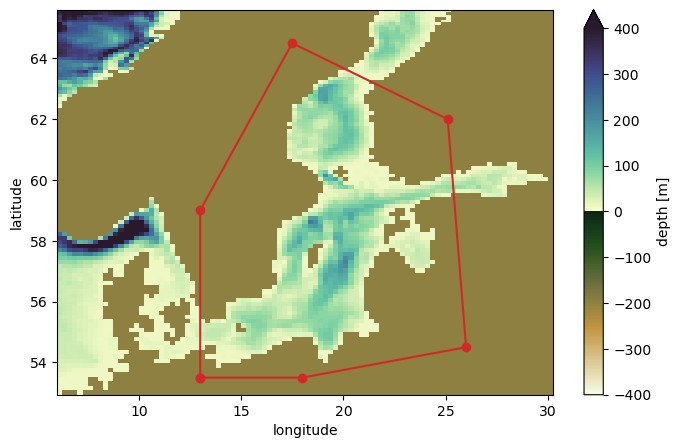

In [191]:
lons = np.array([13., 18, 26., 25.1, 17.5, 13.])
lats = np.array([53.5, 53.5, 54.5, 62., 64.5, 59])

plt.figure(figsize=(8,5))
topo_cmap = cmocean.cm.topo_r.copy()
pc = ocean_grid['deptho'].plot(vmin=-400, vmax=400, cmap=topo_cmap)
pc.colorbar.set_label("depth [m]")
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.title("");
plt.plot(np.append(lons, lons[0]), np.append(lats, lats[0]), "C3o-")
plt.savefig("../figures/xwmb_step1.png", dpi=200, bbox_inches="tight")

#### Step 2: Conform the region's boundary to the target model vorticity grid

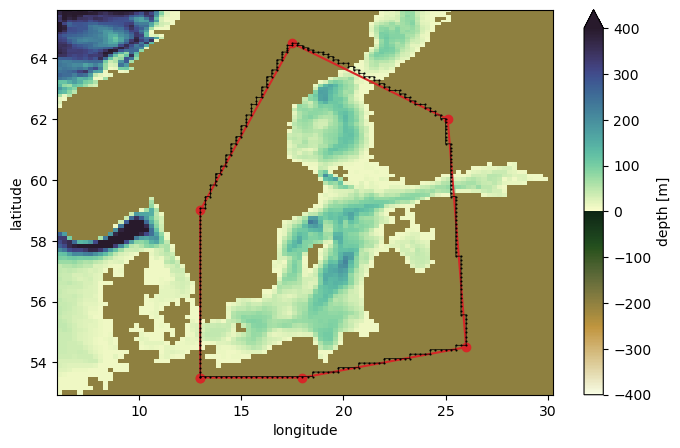

In [279]:
b = reg.conform_basin_to_ocean_grid(reg.Basin(lons, lats, "test"), ocean_grid)

plt.figure(figsize=(8,5))
pc = ocean_grid['deptho'].plot(vmin=-400, vmax=400, cmap=topo_cmap)
pc.colorbar.set_label("depth [m]")
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.title("");
plt.plot(np.append(lons, lons[0]), np.append(lats, lats[0]), "C3o-")
plt.plot(np.append(b.lons, b.lons[0]), np.append(b.lats, b.lats[0]), "k.-", markersize=3, lw=0.5, markeredgewidth=0.)
plt.savefig("../figures/xwmb_step2.png", dpi=200, bbox_inches="tight")

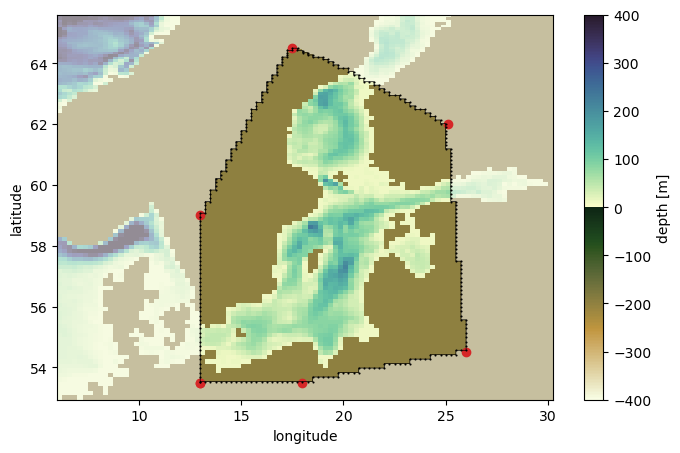

In [193]:
plt.figure(figsize=(8,5))
pc = ocean_grid['deptho'].where(~b.mask).plot(vmin=-400, vmax=400, cmap=topo_cmap, alpha=0.5)
pc.colorbar.remove()
pc = ocean_grid['deptho'].where(b.mask).plot(vmin=-400, vmax=400, cmap=topo_cmap)
pc.colorbar.set_label("depth [m]")
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.title("");
plt.plot(np.append(lons, lons[0]), np.append(lats, lats[0]), "C3o")
plt.plot(np.append(b.lons, b.lons[0]), np.append(b.lats, b.lats[0]), "k.-", markersize=3, lw=0.5, markeredgewidth=0.)
plt.savefig("../figures/xwmb_step3.png", dpi=200, bbox_inches="tight")

#### Step 4: compute changes in water mass volume

In [227]:
theta_min = -4
theta_max = 40.
Δtheta = 0.1
rho0 = 1035.
Cp = 3992.

# Transform budget to theta coordinates
theta_i_bins = np.arange(theta_min - Δtheta*0.5, theta_max + Δtheta*0.5, Δtheta)
theta_l_bins = np.arange(theta_min, theta_max, Δtheta)

ds['speed'] = (
    (grid.interp(ds.umo/ocean_grid.dyCu, "X") + 
     grid.interp(ds.vmo/ocean_grid.dxCv, "Y"))
    /(ds.thkcello*rho0)
)

ds_theta = xwm.transform_to_theta(ds, grid, theta_l_bins, theta_i_bins)

# Transform snapshot mass onto snapshot temperature grid
h_on_temp = grid_snap.transform(
    snap.thkcello,
    'Z',
    target=theta_i_bins,
    target_data=snap.thetao,
    method='conservative'
)
mask = xr.DataArray(b.mask.data, coords=(ds.yh, ds.xh,))

# 
h_on_temp_map = (h_on_temp).where(mask).compute()

# Integrate mass in each temperature layer over the horizontal surface area
M_on_temp = (h_on_temp_map*rho0*ocean_grid.areacello).sum(['xh', 'yh']).compute()
M0 = M_on_temp.isel(time=slice(0, -1)).assign_coords({'time':ds.time})

# Compute the cumulative integral below each of the temperature interfaces (theta_i_bins),
# but omit the value for the last interface because there is no equivalent watermass transformation term
M_below_temp = M_on_temp.cumsum('thetao').rename({'thetao':'thetao_i'}).assign_coords({'thetao_i':theta_i_bins[1:]}).isel(thetao_i=slice(0, -1))

/work/hfd/.conda/envs/generic-xstack/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/work/hfd/.conda/envs/generic-xstack/lib/python3.10/site-packages/xgcm/grid.py:1109: UserWarning: The `target data` input is not located on the cell bounds. This method will continue with linear interpolation with repeated boundary values. For most accurate results provide values on cell bounds.
  warnings.warn(
/work/hfd/.conda/envs/generic-xstack/lib/python3.10/site-packages/xgcm/grid.py:303: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.<function raw_interp_function at 0x2b31906377f0>` instead of `Axis.<function raw_interp_function at 0x2b31906377f0>`
  warnings.warn(
/work/hfd/.conda/envs/ge

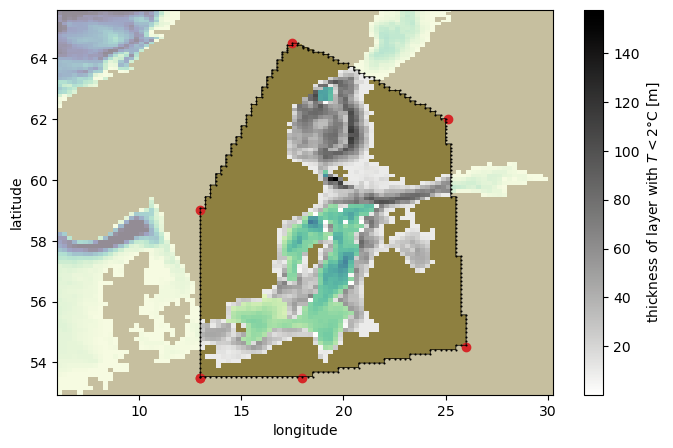

In [229]:
plt.figure(figsize=(8,5))
pc = ocean_grid['deptho'].where(~b.mask).plot(vmin=-400, vmax=400, cmap=topo_cmap, alpha=0.5)
pc.colorbar.remove()
pc = ocean_grid['deptho'].where(b.mask).plot(vmin=-400, vmax=400, cmap=topo_cmap)
pc.colorbar.remove()

layer_thick = h_on_temp_map.mean('time').sel(thetao=slice(-4, 2)).sum("thetao")
pc = layer_thick.where(layer_thick!=0.).plot(cmap=cmocean.cm.gray_r)
pc.colorbar.set_label(r"thickness of layer with $T<2 \degree$C [m]")

plt.xlabel("longitude")
plt.ylabel("latitude")
plt.title("");
plt.plot(np.append(lons, lons[0]), np.append(lats, lats[0]), "C3o")
plt.plot(np.append(b.lons, b.lons[0]), np.append(b.lats, b.lats[0]), "k.-", markersize=3, lw=0.5, markeredgewidth=0.)
plt.savefig("../figures/xwmb_step4.png", dpi=200, bbox_inches="tight")

#### Step 5: compute water mass transformations

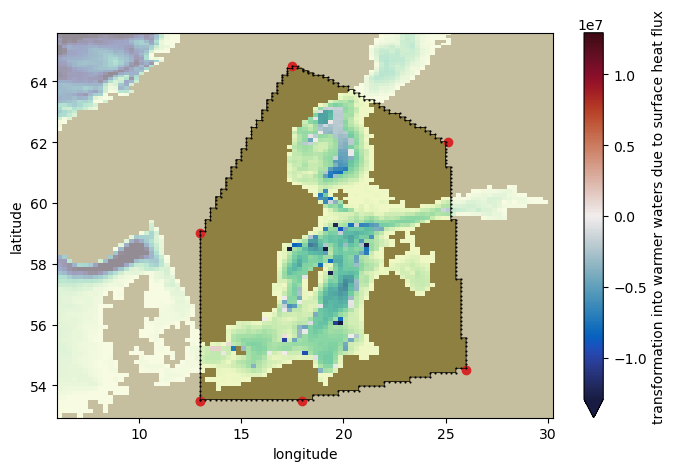

In [230]:
plt.figure(figsize=(8,5))
pc = ocean_grid['deptho'].where(~b.mask).plot(vmin=-400, vmax=400, cmap=topo_cmap, alpha=0.5)
pc.colorbar.remove()
pc = ocean_grid['deptho'].where(b.mask).plot(vmin=-400, vmax=400, cmap=topo_cmap)
pc.colorbar.remove()

G = (rho0*ds_theta.boundary_forcing_heat_tendency.where(b.mask)/(Cp*rho0)*ocean_grid.areacello)/Δtheta
G = G.mean('time').sel(thetao_i=2., method="nearest")
pc = G.where(G!=0.).plot(cmap=cmocean.cm.balance, robust=True)
pc.colorbar.set_label(r"transformation into warmer waters due to surface heat flux")

plt.xlabel("longitude")
plt.ylabel("latitude")
plt.title("");
plt.plot(np.append(lons, lons[0]), np.append(lats, lats[0]), "C3o")
plt.plot(np.append(b.lons, b.lons[0]), np.append(b.lats, b.lats[0]), "k.-", markersize=3, lw=0.5, markeredgewidth=0.)
plt.savefig("../figures/xwmb_step5a.png", dpi=200, bbox_inches="tight")

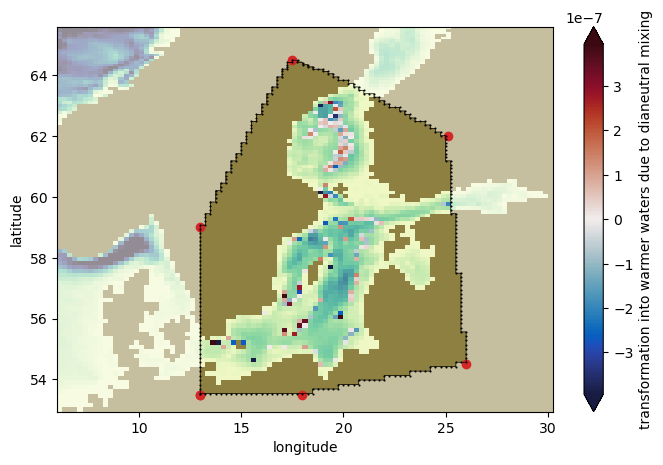

In [231]:
plt.figure(figsize=(8,5))
pc = ocean_grid['deptho'].where(~b.mask).plot(vmin=-400, vmax=400, cmap=topo_cmap, alpha=0.5)
pc.colorbar.remove()
pc = ocean_grid['deptho'].where(b.mask).plot(vmin=-400, vmax=400, cmap=topo_cmap)
pc.colorbar.remove()

G = (rho0*ds_theta.opottempdiff.where(b.mask)/(Cp*rho0)*ocean_grid.areacello)/Δtheta
G = G.mean('time').sel(thetao_i=2., method="nearest")
pc = G.where(G!=0.).plot(cmap=cmocean.cm.balance, robust=True)
pc.colorbar.set_label(r"transformation into warmer waters due to dianeutral mixing")

plt.xlabel("longitude")
plt.ylabel("latitude")
plt.title("");
plt.plot(np.append(lons, lons[0]), np.append(lats, lats[0]), "C3o")
plt.plot(np.append(b.lons, b.lons[0]), np.append(b.lats, b.lats[0]), "k.-", markersize=3, lw=0.5, markeredgewidth=0.)
plt.savefig("../figures/xwmb_step5b.png", dpi=200, bbox_inches="tight")

#### Step 6: compute convergent horizontal transport in layer

/work/hfd/.conda/envs/generic-xstack/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/work/hfd/.conda/envs/generic-xstack/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/work/hfd/.conda/envs/generic-xstack/lib/python3.10/site-packages/numba/np/ufunc/gufunc.py:170: RuntimeWarning: invalid value encountered in _interp_1d_conservative
  return self.ufunc(*args, **kwargs)
/work/hfd/.conda/envs/generic-xstack/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


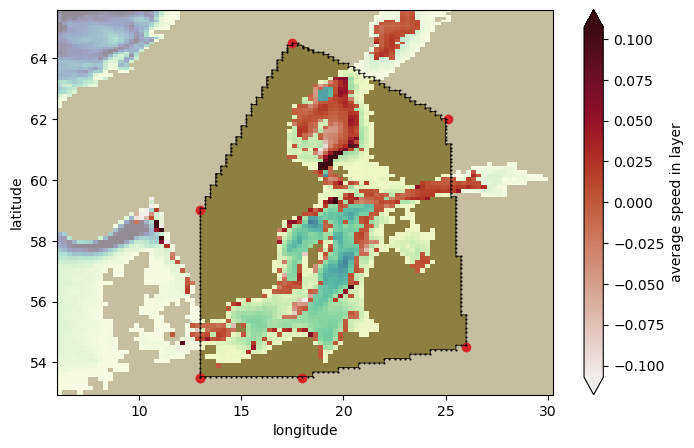

In [273]:
plt.figure(figsize=(8,5))
pc = ocean_grid['deptho'].where(~b.mask).plot(vmin=-400, vmax=400, cmap=topo_cmap, alpha=0.5)
pc.colorbar.remove()
pc = ocean_grid['deptho'].where(b.mask).plot(vmin=-400, vmax=400, cmap=topo_cmap)
pc.colorbar.remove()

speed = ds_theta.speed
speed = speed.mean('time').sel(thetao_i=slice(-4, 2)).sum('thetao_i')
pc = speed.where(speed!=0.).plot(cmap=cmocean.cm.amp, robust=True)
pc.colorbar.set_label(r"average speed in layer")

plt.xlabel("longitude")
plt.ylabel("latitude")
plt.title("");
plt.plot(np.append(lons, lons[0]), np.append(lats, lats[0]), "C3o")
plt.plot(np.append(b.lons, b.lons[0]), np.append(b.lats, b.lats[0]), "k.-", markersize=3, lw=0.5, markeredgewidth=0.)
plt.savefig("../figures/xwmb_step6a.png", dpi=200, bbox_inches="tight")

In [274]:
kwargs = {"layer": grid.axes["Z"].coords['center'], 'interface':grid.axes["Z"].coords['outer']}
symmetric = ocean_grid['geolon'].shape!=ocean_grid['geolon_c'].shape
conv = sec.convergent_transport(ds, b.i, b.j, symmetric, **kwargs)['conv_mass_transport'].compute()
thetao_sec = sec.extract_tracer(ds.thetao, b.i, b.j, symmetric).compute()

# Compute the convergent horizontal transport integrated below each of the temperature interfaces (theta_i_bins),
# but omit the value for the last interface because there is no equivalent watermass transformation term
conv_transport = grid.transform(
    conv.fillna(0.)/rho0*1e-6, 'Z', theta_i_bins, target_data=thetao_sec, method="conservative"
).cumsum('thetao').rename({'thetao':'thetao_i'}).assign_coords({'thetao_i':theta_i_bins[1:]}).isel(thetao_i=slice(0, -1)).compute()

/work/hfd/.conda/envs/generic-xstack/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/work/hfd/.conda/envs/generic-xstack/lib/python3.10/site-packages/xgcm/grid.py:1109: UserWarning: The `target data` input is not located on the cell bounds. This method will continue with linear interpolation with repeated boundary values. For most accurate results provide values on cell bounds.
  warnings.warn(
/work/hfd/.conda/envs/generic-xstack/lib/python3.10/site-packages/xgcm/grid.py:303: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.<function raw_interp_function at 0x2b31906377f0>` instead of `Axis.<function raw_interp_function at 0x2b31906377f0>`
  warnings.warn(
/work/hfd/.conda/envs/ge

/work/hfd/.conda/envs/generic-xstack/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/work/hfd/.conda/envs/generic-xstack/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/work/hfd/.conda/envs/generic-xstack/lib/python3.10/site-packages/numba/np/ufunc/gufunc.py:170: RuntimeWarning: invalid value encountered in _interp_1d_conservative
  return self.ufunc(*args, **kwargs)
/work/hfd/.conda/envs/generic-xstack/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


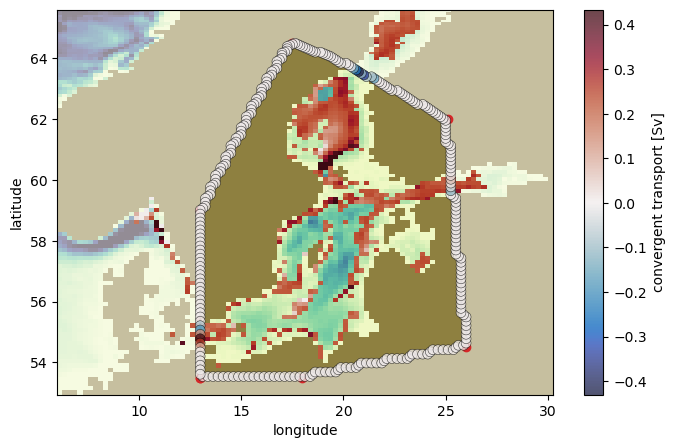

In [278]:
plt.figure(figsize=(8,5))
pc = ocean_grid['deptho'].where(~b.mask).plot(vmin=-400, vmax=400, cmap=topo_cmap, alpha=0.5)
pc.colorbar.remove()
pc = ocean_grid['deptho'].where(b.mask).plot(vmin=-400, vmax=400, cmap=topo_cmap)
pc.colorbar.remove()

speed = ds_theta.speed
speed = speed.mean('time').sel(thetao_i=slice(-4, 2)).sum('thetao_i')
pc = speed.where(speed!=0.).plot(cmap=cmocean.cm.amp, robust=True)
pc.colorbar.remove()

sc = plt.scatter(
    b.lons_uv,
    b.lats_uv,
    s=50,
    c=conv_transport.mean('time').sel(thetao_i=slice(-4, 2)).sum('thetao_i'),
    cmap=cmocean.cm.balance,
    alpha=0.75,
    edgecolors="k", linewidths=0.4,
)
sc.set_zorder(np.inf)
cb = plt.colorbar(sc)
cb.set_label("convergent transport [Sv]")

plt.xlabel("longitude")
plt.ylabel("latitude")
plt.title("");
plt.plot(np.append(lons, lons[0]), np.append(lats, lats[0]), "C3o")
plt.plot(np.append(b.lons, b.lons[0]), np.append(b.lats, b.lats[0]), "k.-", markersize=3, lw=0.5, markeredgewidth=0.)
plt.savefig("../figures/xwmb_step6b.png", dpi=200, bbox_inches="tight")